In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from numpy.random import randint

stops = set(stopwords.words('english'))

%matplotlib inline
sns.set_style("whitegrid")
pd.set_option('display.max_colwidth',150)

In [2]:
def get_emotion_data(emotion_name, column_names = ['id','text','emotion','intensity']):
    train_data = pd.read_csv('source_data/train/{0}-ratings-0to1.train.txt'.format(emotion_name),
                             delimiter='\t',header=None, names = column_names)
    dev_data = pd.read_csv('source_data/dev/{0}-ratings-0to1.dev.gold.txt'.format(emotion_name),
                           delimiter='\t',header=None, names = column_names)
    test_data = pd.read_csv('source_data/test/{0}-ratings-0to1.test.gold.txt'.format(emotion_name),
                            delimiter='\t',header=None, names = column_names)
    
    return train_data, dev_data, test_data

In [3]:
def clean_text(text, remove_stopwords=True):
    text = re.sub(r"@\w{1,15}", "@USERNAME", text)
    text = re.sub(r'\\n',' ',text)
    text = re.sub(r'&amp',' ',text)
    text = re.sub(r"[^A-Za-z0-9^,!.#\/'+=@]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " !", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    
    text = text.lower().split()
    
    if remove_stopwords:
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)
    
    return text

In [4]:
main_emotions = ['anger','fear','joy','sadness']

full_data={}
bfull_Y = {}
for emotion in main_emotions:
    full_data[emotion] = get_emotion_data(emotion)
    
    for data in full_data[emotion]:
        data['cleaned_text'] = data['text'].map(clean_text)

## Размерность датасетов

/opt/lab/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


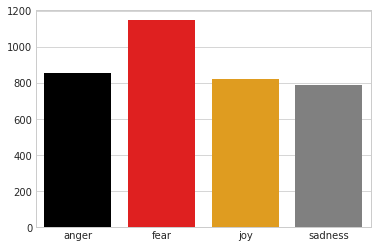

In [6]:
bar_plot_axes = sns.barplot(x=main_emotions, y=[len(full_data[emotion][0])for emotion in main_emotions],
            palette=['black','red','orange','gray'])

## Гистограмма интенсивности для каждой эмоции

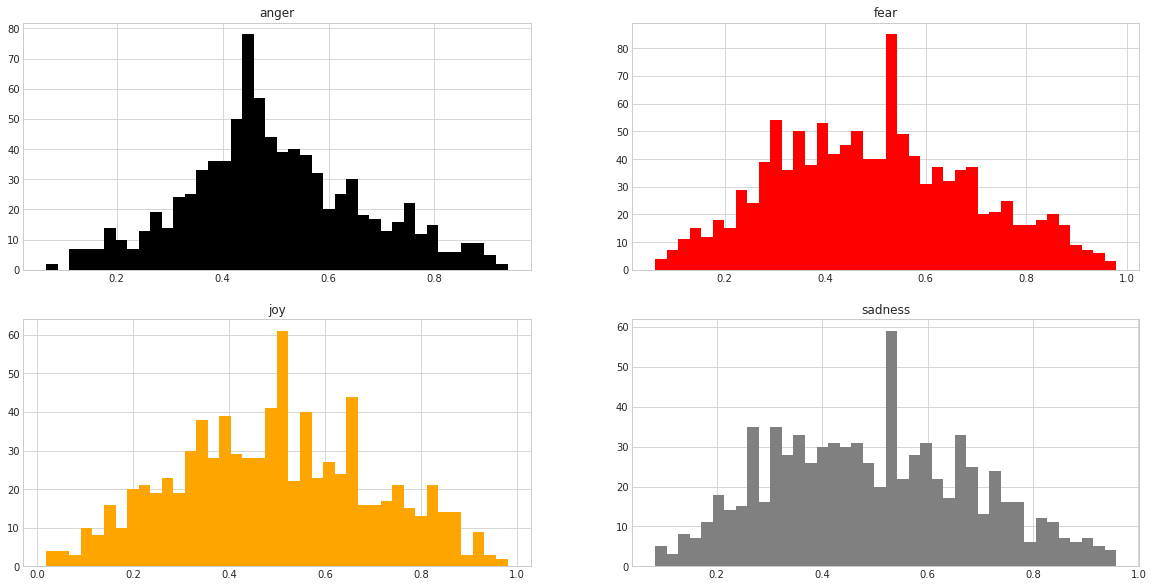

In [8]:
emotion2color = {'anger':'black',
                 'fear':'red',
                 'joy':'orange',
                 'sadness':'gray'}
fig = plt.figure(figsize=(20,10))
for i,emotion in enumerate(main_emotions):
    ax = fig.add_subplot(2,2,i+1)
    ax.hist(full_data[emotion][0]['intensity'], bins=40,color=emotion2color[emotion])
    ax.set_title(emotion)
fig.savefig("emo_hist.png")
plt.show()

## Наиболее популярные слова

In [9]:
def get_color_func(emotion):
    
    def color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
        if emotion == 'sadness':
            return "hsl({0},{1}%,{2}%)".format(0,0,randint(50,80))
        if emotion == 'fear':
            return "hsl({0},{1}%,{2}%)".format(0,82,randint(10,40))
        if emotion == 'joy':
            return "hsl({0},{1}%,{2}%)".format(randint(25,40),randint(80,100),randint(40,60))
        return "hsl({0},{1}%,{2}%)".format(randint(0,5),randint(0,5),randint(0,10))
    return color_func

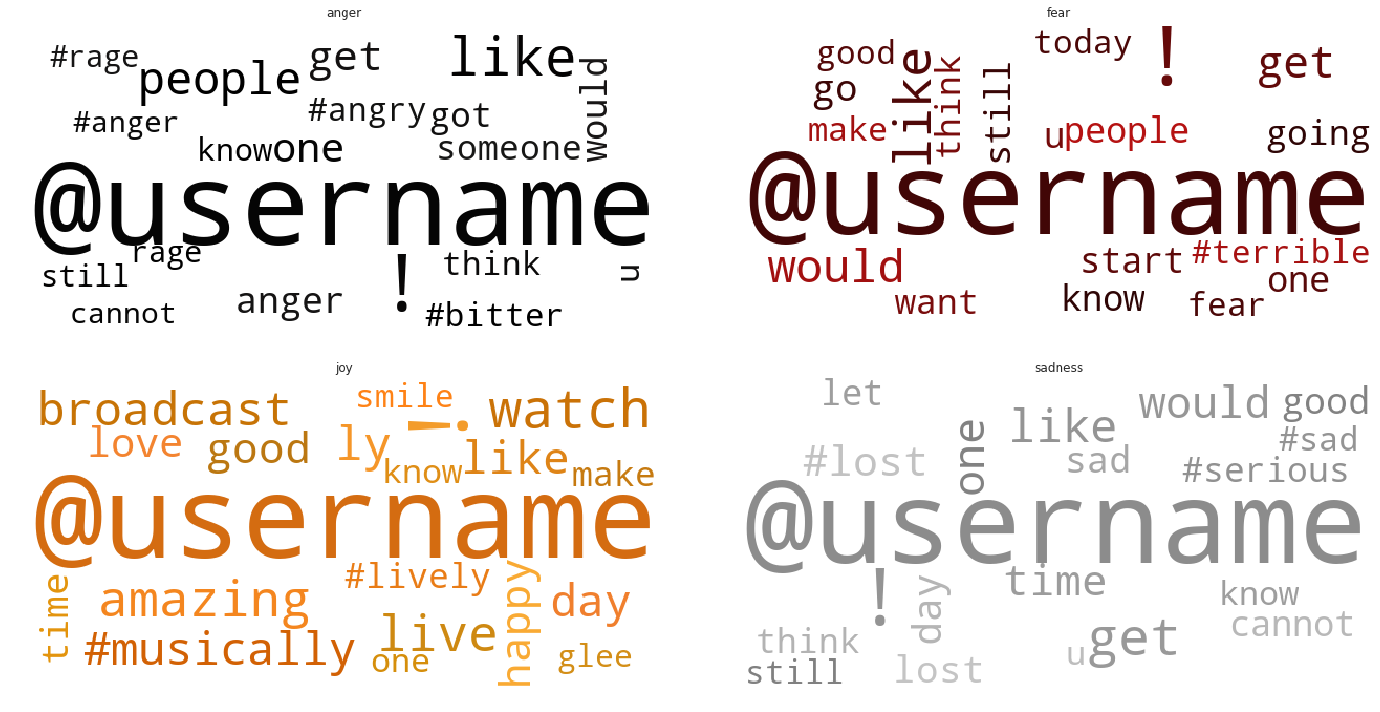

In [11]:
fig = plt.figure(figsize=(20, 10))
top_words_count = 20
for i, emotion in enumerate(main_emotions):
    words_sequence = full_data[emotion][0]['cleaned_text'].str.split(expand=True).unstack().value_counts()
    word_freqs = dict(zip(words_sequence.index[:top_words_count], words_sequence.values[:top_words_count]))
    wс= WordCloud(max_font_size=250, 
                  height=300, 
                  width=600,
                  background_color='white',).generate_from_frequencies(word_freqs)
    default_colors = wс.to_array()
    wс =wс.recolor(color_func=get_color_func(emotion), random_state=3)
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(emotion)
    ax.imshow(wс)
    ax.axis("off")
        
fig.tight_layout()
plt.show()

## Качество датасета

### Дубликаты

In [12]:
def find_first_duplicate(data, twit_id, sentence):
    first_word_count = 13
    prefix = sentence[:first_word_count]
    ids = data[(data['text'].str.contains(prefix)) & (data['id']!=twit_id)]['id'].values
    if len(ids)==0:
        return np.nan
    return ids[0]

In [13]:
train_anger = full_data['anger'][0]

In [14]:
train_anger['duplicate'] = train_anger.apply(lambda row: find_first_duplicate(train_anger, 
                                                                              row['id'], 
                                                                              row['text']),axis=1)

In [15]:
duplicate_example = pd.merge(train_anger[~train_anger['duplicate'].isnull()], 
         train_anger[['id','text','intensity']],
         how='left',
         left_on='duplicate', right_on='id', 
         suffixes=('_left', '_right'))[['text_left','intensity_left','text_right','intensity_right']]

In [16]:
duplicate_example.head(6)

,text_left,intensity_left,text_right,intensity_right
0,So my Indian Uber driver just called someone the N word. If I wasn't in a moving vehicle I'd have jumped out #disgusted,0.896,So my Indian Uber driver just called someone the N word. If I wasn't in a moving vehicle I'd have jumped out #disgusted #offended,0.729
1,@DPD_UK I asked for my parcel to be delivered to a pick up store not my address #fuming #poorcustomerservice,0.896,@DPD_UK I asked for my parcel to be delivered to a pick up store not my address #poorcustomerservice,0.625
2,so ef whichever butt wipe pulled the fire alarm in davis bc I was sound asleep #pissed #angry #upset #tired #sad #tired #hangry ######,0.896,so ef whichever butt wipe pulled the fire alarm in davis bc I was sound asleep #pissed #upset #tired #sad #tired #hangry ######,0.771
3,"Don't join @BTCare they put the phone down on you, talk over you and are rude. Taking money out of my acc willynilly! #fuming",0.896,"Don't join @BTCare they put the phone down on you, talk over you and are rude. Taking money out of my acc willynilly!",0.604
4,My blood is boiling,0.875,@ArizonaCoyotes not to mention the GRA guy stops me but let's the 2 ppl in front of me go. WTF. My blood is boiling.,0.854
5,When you've still got a whole season of Wentworth to watch and a stupid cunt in work ruins it for us 😭😭 @__KirstyGA #raging #oldcunt,0.875,When you've still got a whole season of Wentworth to watch and a stupid cunt in work ruins it for us 😭😭 @__KirstyGA #oldcunt,0.625


### Сарказм

In [17]:
train_anger[train_anger['id'] == 10050][['id','text','emotion','intensity']]

,id,text,emotion,intensity
50,10050,Im so angry 😂🙃,anger,0.75
